This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/robot.html).  I recommend having both windows open, side-by-side!

In [1]:
from pydrake.all import (
    DiagramBuilder,
    MeshcatVisualizer,
    Simulator,
    StartMeshcat,
)

from manipulation.station import load_scenario, MakeHardwareStation
from manipulation.utils import RenderDiagram

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://4e4bcb41-cafd-436c-bda4-33dbe7202b60.deepnoteproject.com/7001/


# A simple bimanual manipulation example

The `MakeHardwareStation` code will add all of the controller code / logic for you, even if you have multiple iiwa/wsg-pairs in the scene.

INFO:drake:Meshcat listening for connections at http://localhost:7002


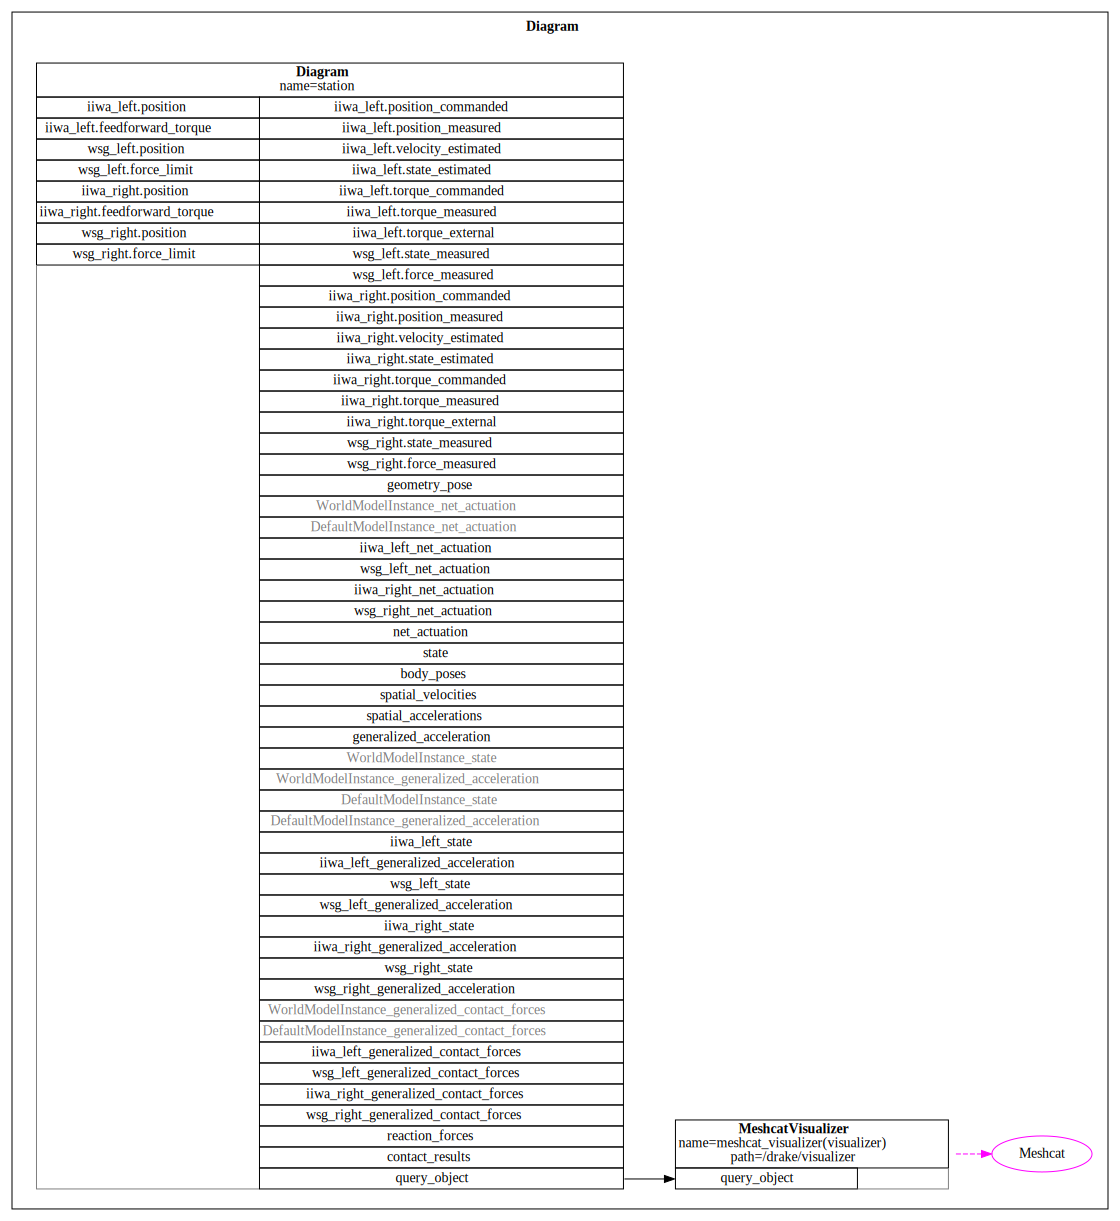

In [3]:
scenario_data = """
directives:
- add_model:
    name: iiwa_left
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa_left::iiwa_link_0
- add_model:
    name: wsg_left
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa_left::iiwa_link_7
    child: wsg_left::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: iiwa_right
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa_right::iiwa_link_0
    X_PC:
        translation: [.6, 0, 0]
        rotation: !Rpy { deg: [0, 0, 0]}
- add_model:
    name: wsg_right
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa_right::iiwa_link_7
    child: wsg_right::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
model_drivers:
    iiwa_left: !IiwaDriver
      hand_model_name: wsg_left
    wsg_left: !SchunkWsgDriver {}
    iiwa_right: !IiwaDriver
      hand_model_name: wsg_right
    wsg_right: !SchunkWsgDriver {}
"""

scenario = load_scenario(data=scenario_data)
builder = DiagramBuilder()

station = builder.AddSystem(MakeHardwareStation(scenario))
plant = station.GetSubsystemByName("plant")
controller_plant = station.GetSubsystemByName(
    "iiwa_left.controller"
).get_multibody_plant_for_control()

visualizer = MeshcatVisualizer.AddToBuilder(
    builder, station.GetOutputPort("query_object"), meshcat
)

diagram = builder.Build()

RenderDiagram(diagram, max_depth=1)

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyMutableContextFromRoot(context)
plant_context = plant.GetMyMutableContextFromRoot(context)

q0 = plant.GetPositions(
    plant_context, plant.GetModelInstanceByName("iiwa_left")
)
station.GetInputPort("iiwa_left.position").FixValue(station_context, q0)
station.GetInputPort("iiwa_right.position").FixValue(station_context, q0)

station.GetInputPort("wsg_left.position").FixValue(station_context, [0])
station.GetInputPort("wsg_right.position").FixValue(station_context, [0])

# Confirm that simulation works:
simulator.AdvanceTo(0.1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e4bcb41-cafd-436c-bda4-33dbe7202b60' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>